In [32]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure7/output_fig7/'

from scripts.io_library import MyLib
from scripts.utils import Utils
from scripts.visualization import MyVisualization
from scripts.clustering_utils import Clustering
# from scripts.differential_expression_utils import DE
from scripts.invoking_R_functions import MyRFunctions

In [33]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
data_dir = ''
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]

upset_file = 'cell_lines_master_upset_2024-4-13.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[(raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype'] != 'HCC')]
upset_df = upset_df[["Subtype"]]

gene_effect_df = gene_effect_df.loc[upset_df.index]

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
top_mut_df = top_mut_df[["FGFR2$","BAP1$", "IDH1/2$","BRAF$","SMAD4$", "KRAS$", "TP53$" ]]
# upset_mut_df = pd.concat([upset_df, top_mut_df.loc[upset_df.index, :]], axis=1)

rna_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
rna_upset_df = pd.read_csv(rna_upset_file, index_col=0)
protein_upset_file = 'Figure6/output_fig6/Protein_reordered_upset_df.csv'
protein_upset_df = pd.read_csv(protein_upset_file, index_col=0)
shared_lines = sorted(set(rna_upset_df.index).intersection(set(protein_upset_df.index)))
rna_protein_upset_df = rna_upset_df[['Subtype']]
rna_protein_upset_df.loc[shared_lines, 'Protein_Cluster'] = protein_upset_df.loc[shared_lines, 'Cluster']
rna_protein_upset_df[['RNA_Cluster']] = rna_upset_df[['RNA_Cluster']]
# df = pd.concat([upset_mut_df, rna_protein_upset_df[['RNA_Cluster', 'Protein_Cluster']]], axis=1)
df = pd.concat([upset_df, rna_protein_upset_df[['RNA_Cluster', 'Protein_Cluster']], top_mut_df.loc[upset_df.index, :]], axis=1)
upset_mut_df = df.loc[upset_df.index]

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2024-4-13.csv  is loaded, shape:  (87, 10)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)



In [35]:
upset_mut_df

,Subtype,RNA_Cluster,Protein_Cluster,FGFR2$,BAP1$,IDH1/2$,BRAF$,SMAD4$,KRAS$,TP53$
Cell_line,,,,,,,,,,
SNU869,AC,R4,P5,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE,NaN
SNU478,AC,R4,P5,NaN,NaN,NaN,NaN,NaN,NaN,FRAME_SHIFT_INS
TGBC52TKB,AC,R1,P3,NaN,NaN,NaN,NaN,NaN,MISSENSE,NaN
AOVC1,AC,R4,P5,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
TGBC18TKB,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSENSE
SNU1196,ECC,R4,P5,NaN,NaN,NaN,NaN,NONSENSE,NaN,MISSENSE
EGI1,ECC,R4,P3,NaN,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE
KKU100,ECC,R1,P3,NaN,NaN,NaN,NaN,SPLICE_SITE,MISSENSE,NaN
TFK1,ECC,R4,P3,NaN,NONSENSE,NaN,NaN,NaN,NaN,NONSENSE


# normLRT across BTC cell lines

In [36]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])


input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



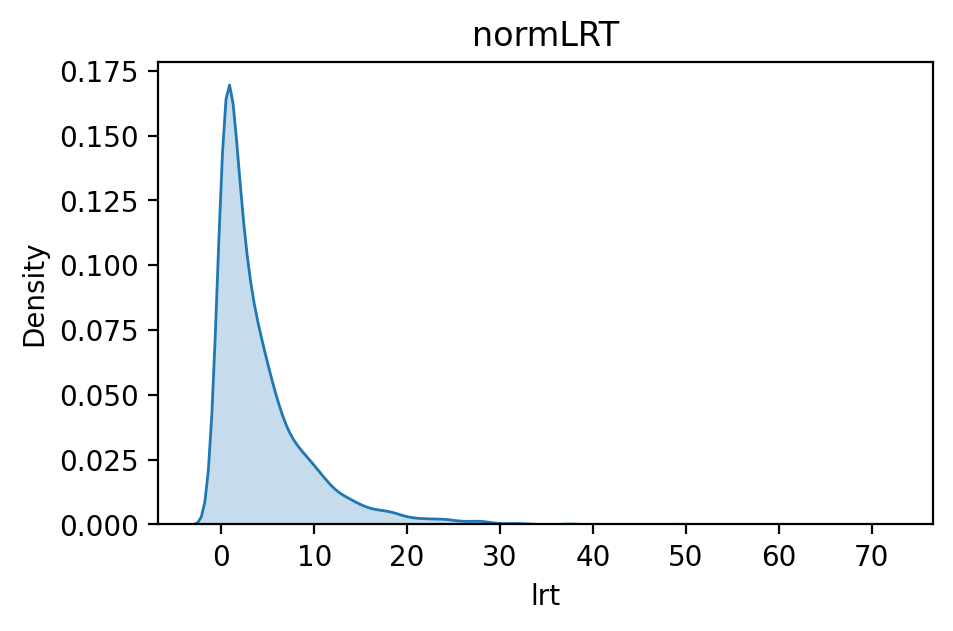

In [37]:
MyVisualization.plot_distribution(lrt_df['lrt'], 'normLRT')

## Clustering of the most variable outlier dependencies

In [38]:
gene_effect_filtered_df = Clustering.select_variable_features(gene_effect_df.dropna(axis=1), variance_percentile_cutoff=85)

threshold = np.percentile(lrt_df['lrt'].dropna(), 90)
genes_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['gene'].tolist() if g in gene_effect_df.columns]

selected_genes_l = list(set(genes_l).intersection(gene_effect_filtered_df.columns))
gene_effect_lrt_filtered_df = gene_effect_filtered_df[selected_genes_l]
corr_gene_effect_lrt_filtered_df = pd.DataFrame(np.corrcoef(gene_effect_lrt_filtered_df.values),
columns=gene_effect_lrt_filtered_df.index, index=gene_effect_lrt_filtered_df.index)
gene_effect_lrt_filtered_df = gene_effect_lrt_filtered_df.rename(columns={col:col.split(' (')[0] for col in gene_effect_lrt_filtered_df.columns})
gene_effect_lrt_filtered_df.shape


(39, 417)

In [39]:
volcano_axes_lim_dic={'D1':(5,0,1,None,None,1), 'D2':(5,0,2,None,None,2), 'D3':(5,0,1,None,None,1), 'D4':(5,0,1,None,None,1), 'D5':(5,0,1,None,None,1), 'D6':(5,0,1,None,None,1)}


File  Figure7/output_fig7/all_D1_features_Down.csv saved, shape: (61, 4)


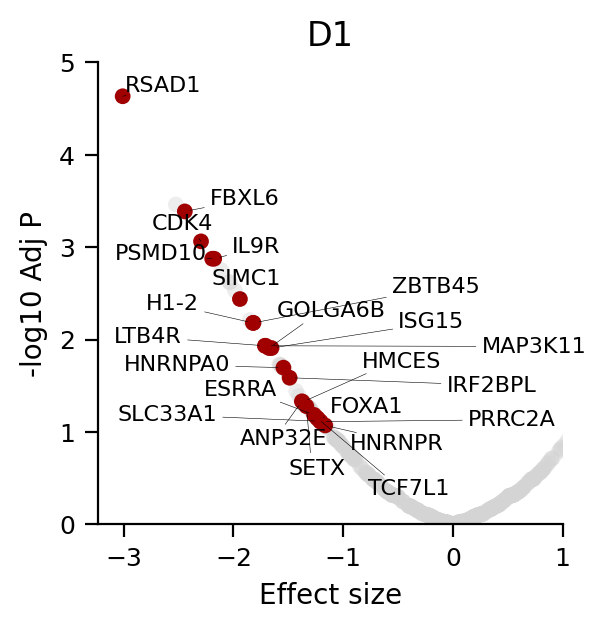


File  Figure7/output_fig7/D1_features_Down.csv saved, shape: (23, 3)

File  Figure7/output_fig7/all_D2_features_Down.csv saved, shape: (5, 4)


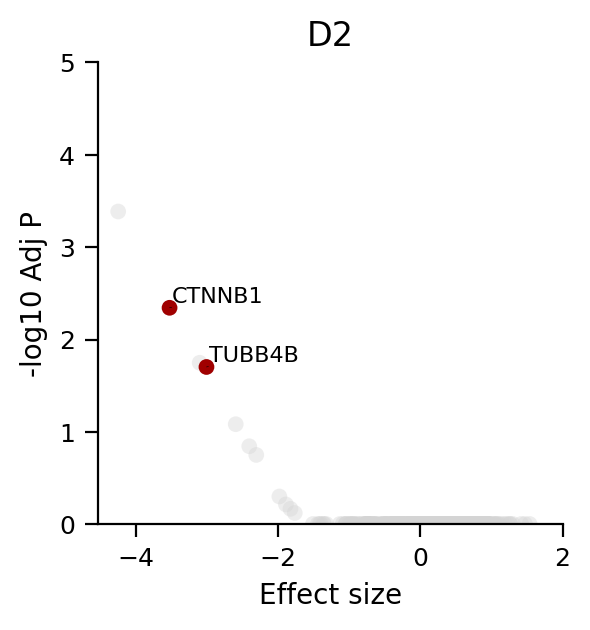


File  Figure7/output_fig7/D2_features_Down.csv saved, shape: (2, 3)

File  Figure7/output_fig7/all_D3_features_Down.csv saved, shape: (9, 4)


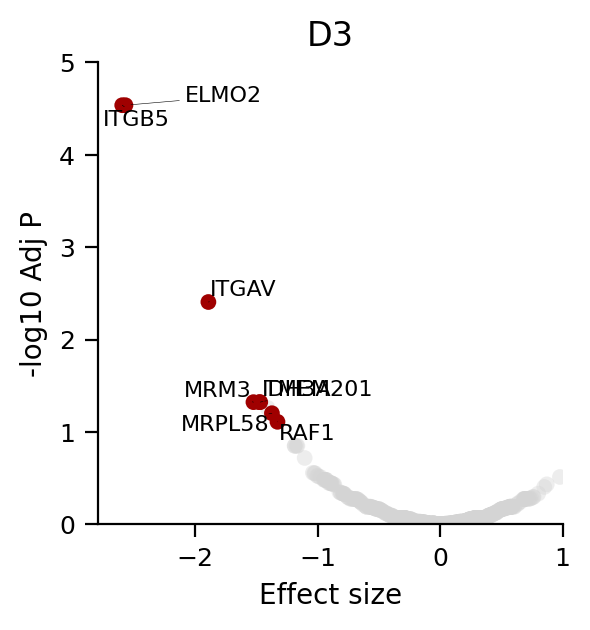


File  Figure7/output_fig7/D3_features_Down.csv saved, shape: (8, 3)

File  Figure7/output_fig7/all_D4_features_Down.csv saved, shape: (13, 4)


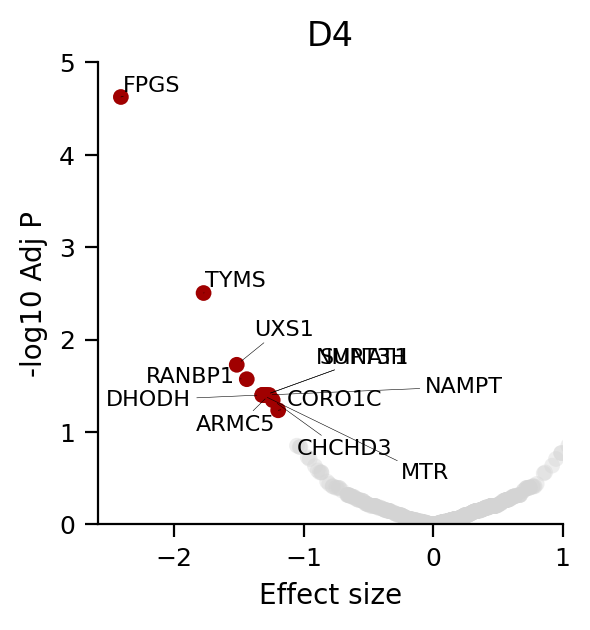


File  Figure7/output_fig7/D4_features_Down.csv saved, shape: (12, 3)

File  Figure7/output_fig7/all_D5_features_Down.csv saved, shape: (16, 4)


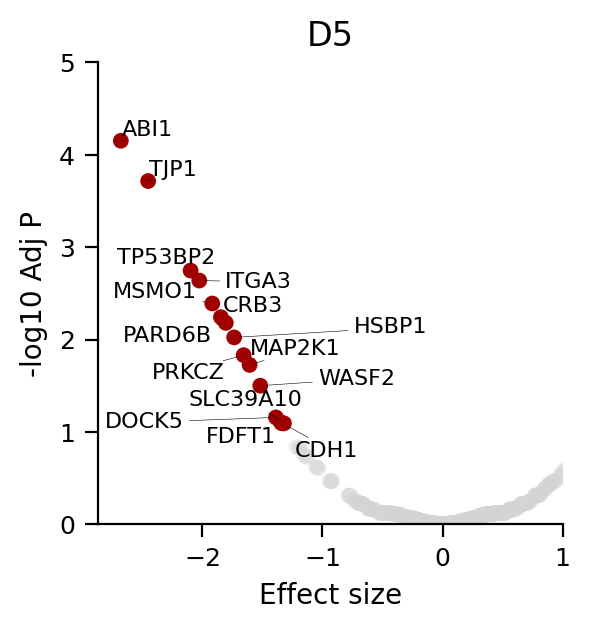


File  Figure7/output_fig7/D5_features_Down.csv saved, shape: (15, 3)

File  Figure7/output_fig7/all_D6_features_Down.csv saved, shape: (2, 4)


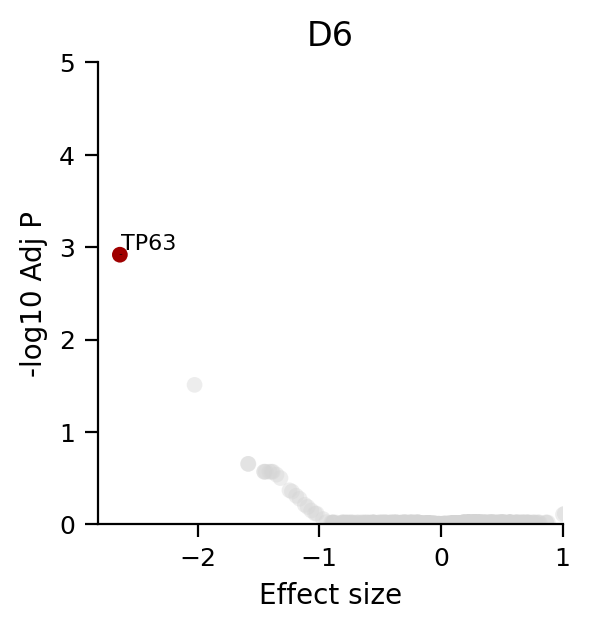


File  Figure7/output_fig7/D6_features_Down.csv saved, shape: (1, 3)

File  Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv saved, shape: (39, 4)


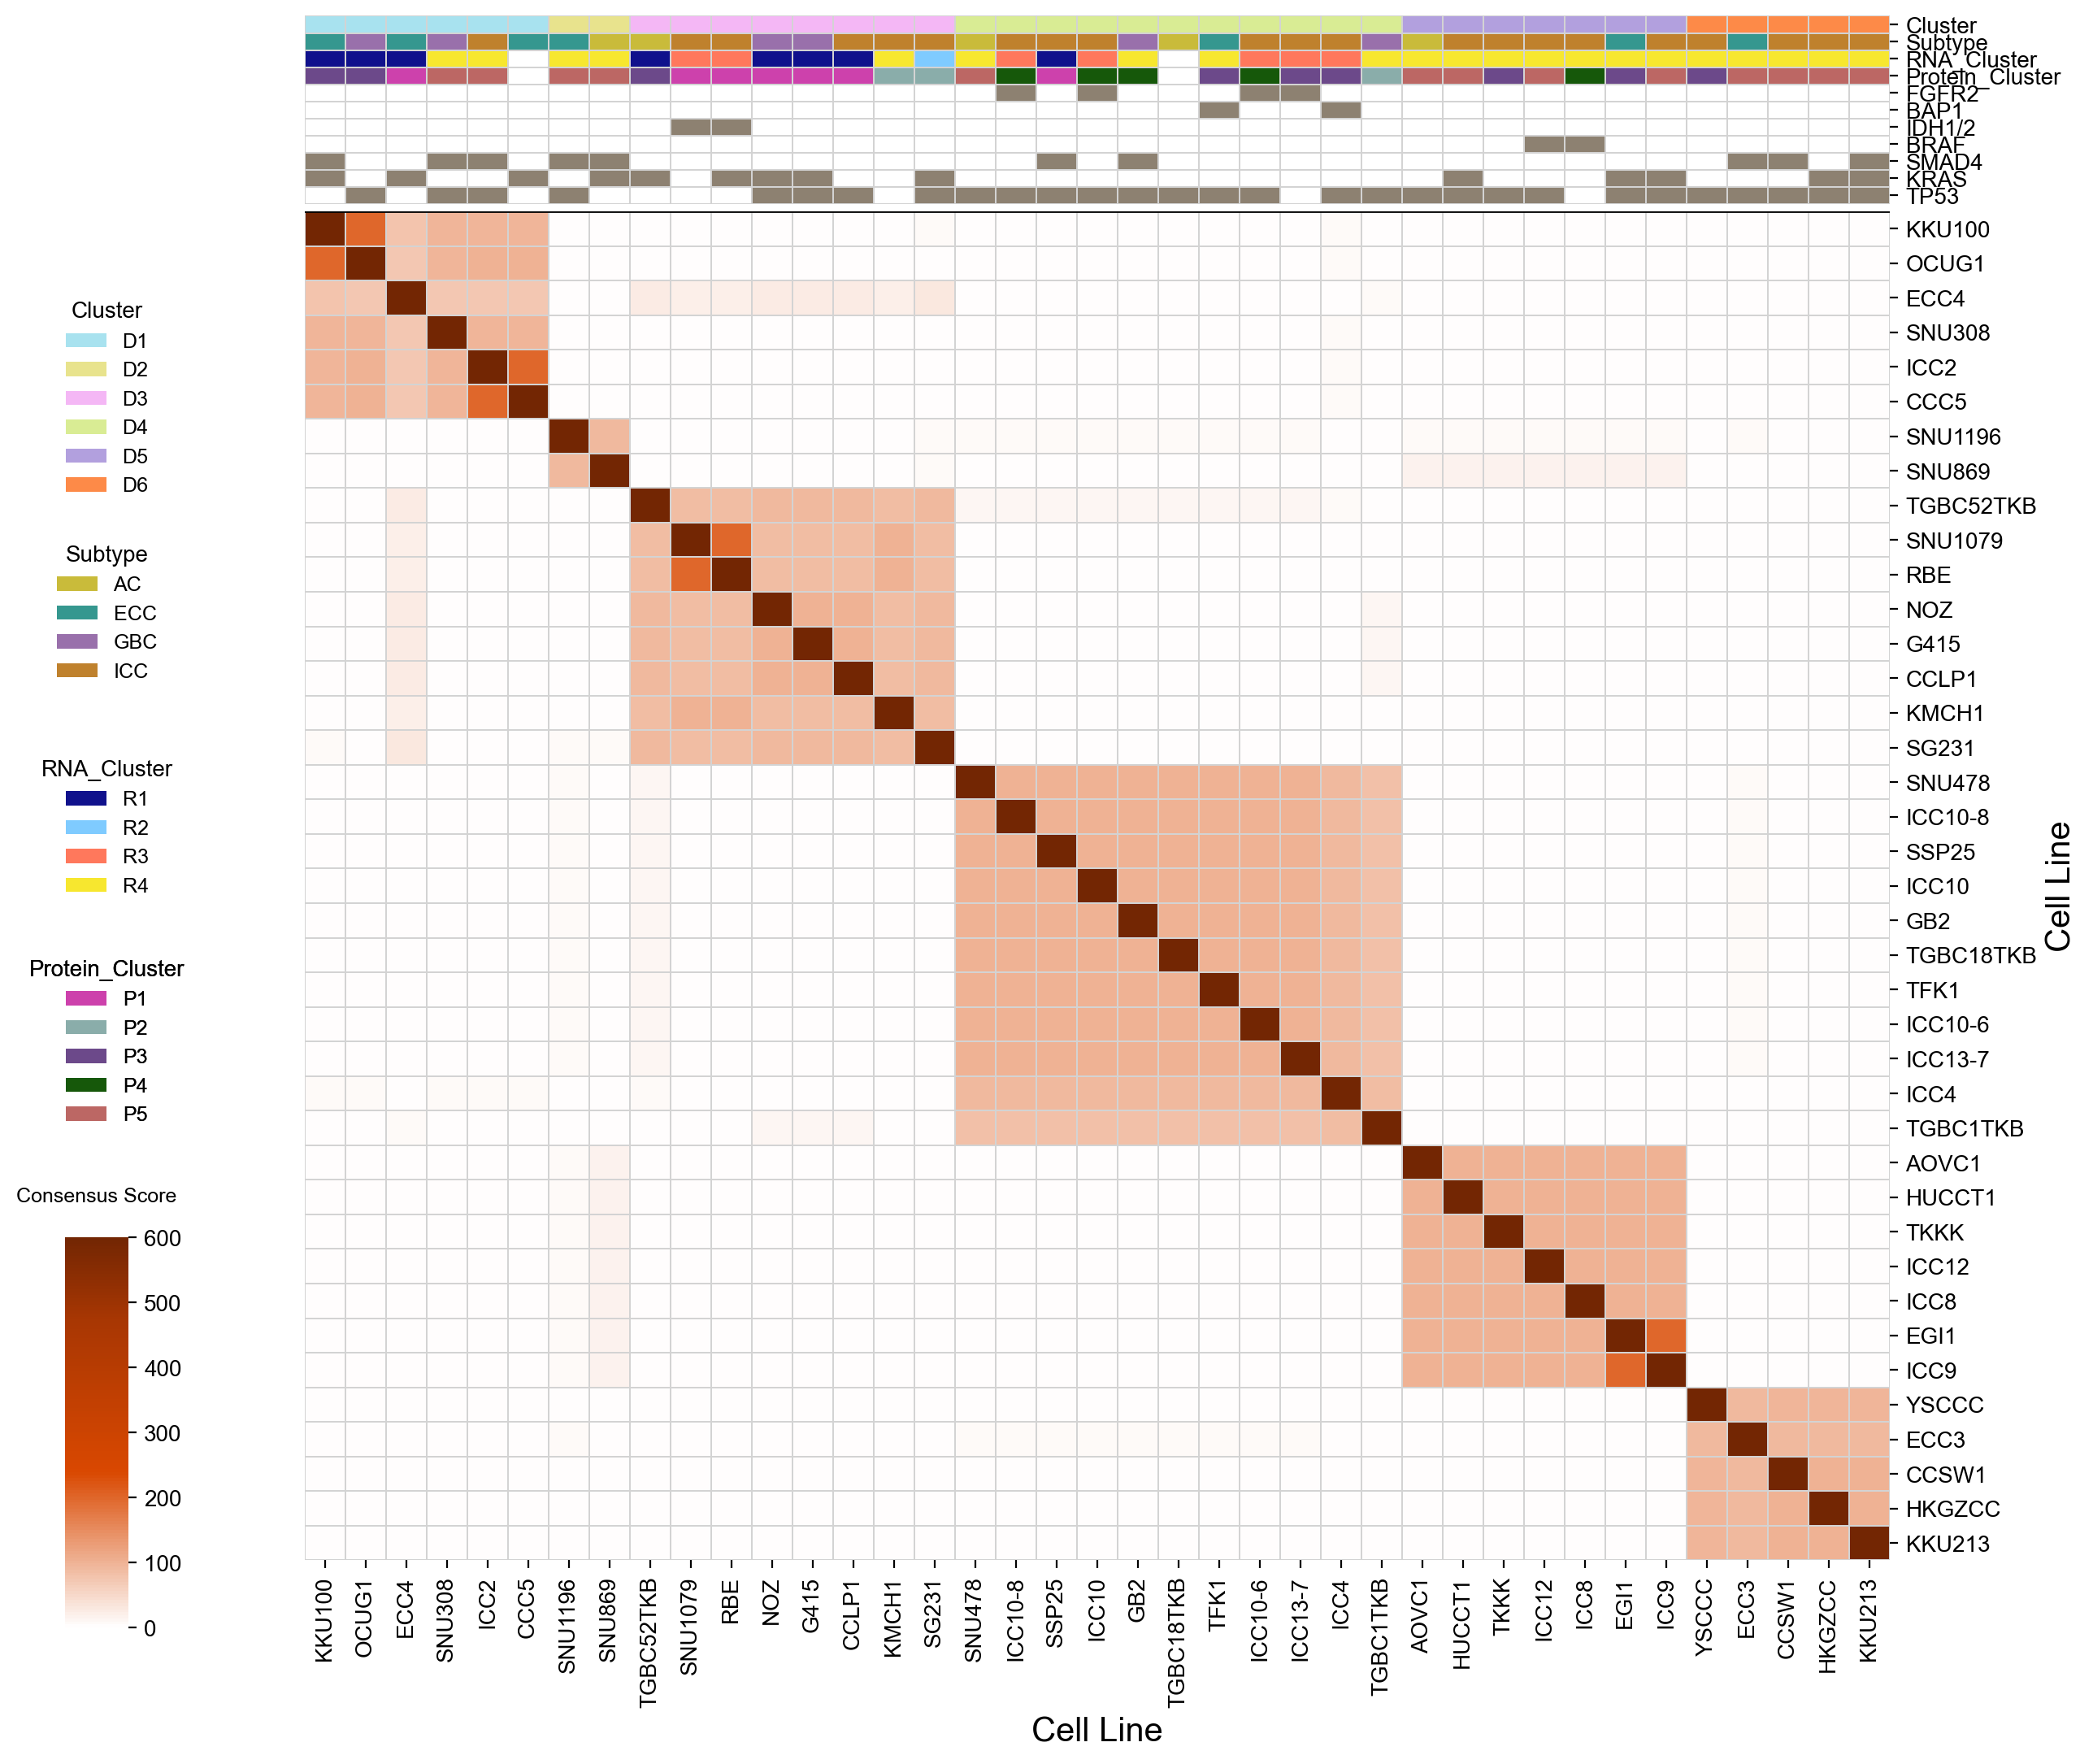

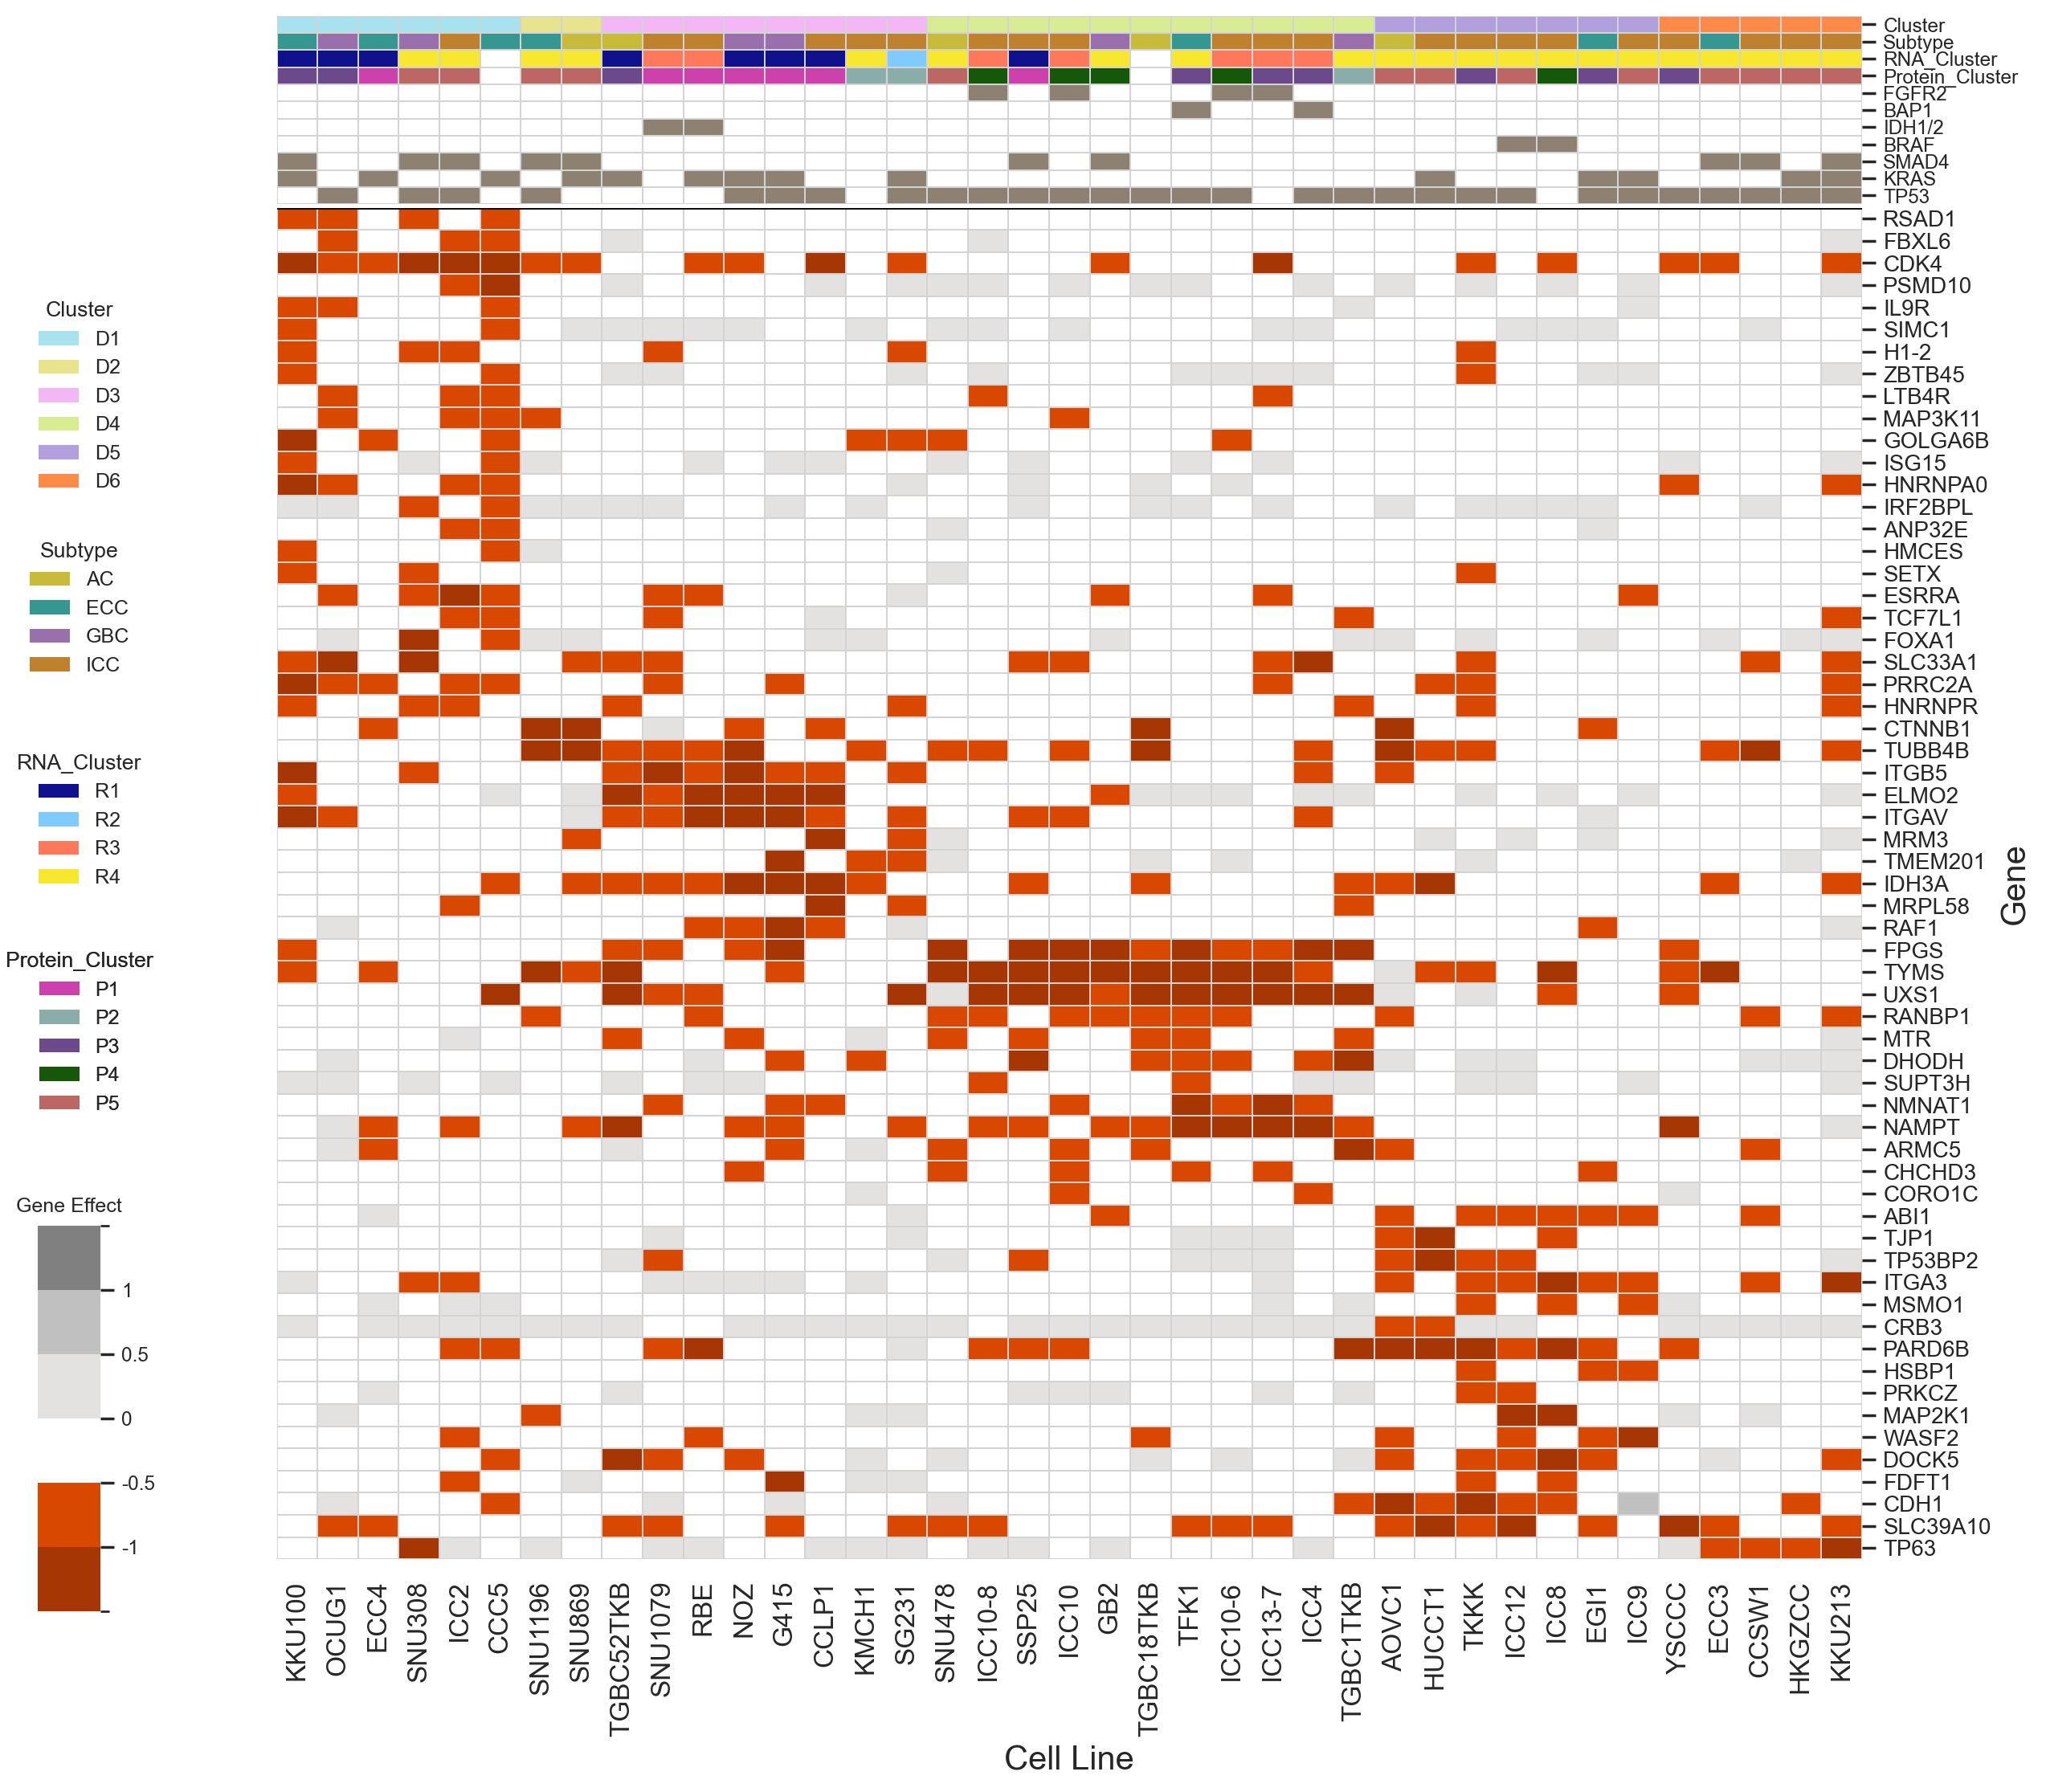

In [40]:
gammas = [1, 1.5, 2, 2.5, 3, 3.5] #

labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_gene_effect_lrt_filtered_df, gammas=gammas)
# up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(gene_effect_lrt_filtered_df, corr_gene_effect_lrt_filtered_df, upset_mut_df, labels_np, consensus_ite, cluster_prefix='D', cbar_title='Gene Effect', row_label='Gene', up=False, ttest=True, q_val_thr=0.1, filter=True, row_cluster=False, event_legend = False, event_color='#8D0741', reverse=True, ytick_fontsize=10, xtick_fontsize=12, cbar_discrete=True, cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, volcano_force_text=0.9, clusters_type_filename='LRT_')

clusters_reordering = [5, 1, 3, 2, 4, 6]
up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(gene_effect_lrt_filtered_df, corr_gene_effect_lrt_filtered_df, upset_mut_df, labels_np, consensus_ite, clusters_reordering=clusters_reordering, cluster_prefix='D', cbar_title='Gene Effect', row_label='Gene', up=False, ttest=True, q_val_thr=0.1, gene_effect_thr=-0.5, row_cluster=False, event_legend = False, event_color='#8D8171', reverse=True, ytick_fontsize=10, xtick_fontsize=12, cbar_discrete=True, cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, volcano_force_text=.5, plot_volcano=True, clusters_type_filename='LRT_', volcano_axes_lim_dic=volcano_axes_lim_dic, cut_off_labels_top=0, save_figure=True)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)

D1
D2
D3
D4
D5
D6

File  Figure7/output_fig7/adjusted_rand_index_stats_CRISPR_Clustering.csv saved, shape: (33, 6)

File  Figure7/output_fig7/adjusted_rand_scores_Clustering SimilaritiesCRISPR_Clustering.csv saved, shape: (16, 6)


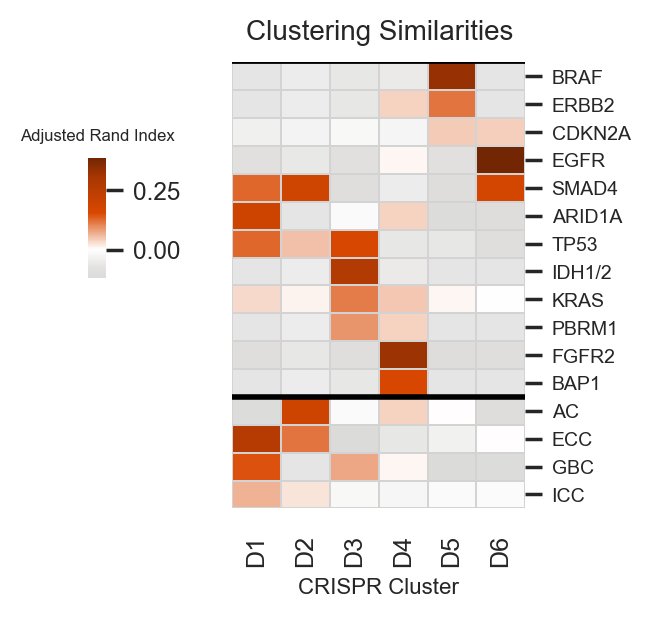

(            D1      D2      D3      D4      D5      D6
 BRAF       1.0     1.0     1.0     1.0   0.031     1.0
 ERBB2      1.0     1.0     1.0  0.4954  0.3302     1.0
 CDKN2A     1.0     1.0   0.686  0.8048  0.2404  0.2762
 EGFR       1.0     1.0     1.0  0.6448     1.0  0.0398
 SMAD4   0.1706  0.0608     1.0  0.8612     1.0  0.1038
 ARID1A  0.1598     1.0  0.6994  0.4482     1.0     1.0
 TP53    0.1578  0.4498  0.0922     1.0  0.8978     1.0
 IDH1/2     1.0     1.0  0.0336     1.0     1.0     1.0
 KRAS     0.363   0.596  0.0886  0.1266  0.5024  0.5946
 PBRM1      1.0     1.0  0.3808   0.479     1.0     1.0
 FGFR2      1.0     1.0     1.0  0.0048     1.0     1.0
 BAP1       1.0     1.0     1.0  0.0742     1.0     1.0
 AC         1.0  0.2372  0.7014   0.432  0.6598     1.0
 ECC      0.058  0.3256     1.0  0.9264  0.7804  0.6592
 GBC     0.2218     1.0  0.3576  0.5576     1.0     1.0
 ICC     0.0684  0.1976     1.0     1.0    0.68  0.6522,
               D1      D2      D3       D4     

In [41]:
if new_upset_df is not None:
    LRT_upset_df = new_upset_df[['Cluster', 'Subtype']].copy()
else:
    LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
    LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
feat_df = top_mut_df.loc[LRT_upset_df.index, ]
feat_df.columns = [c.replace('$', '') for c in feat_df.columns]
feat_df = feat_df.fillna(0)

for f in feat_df.columns:
    feat_df[f] = feat_df[f].apply(lambda x:1 if x!=0 else 0)
for c in LRT_upset_df['Subtype'].unique():
    feat_df[c] = LRT_upset_df['Subtype'].apply(lambda x:1 if x==c else 0)
feats = ['BRAF', 'ERBB2','CDKN2A', 'EGFR', 'SMAD4','ARID1A', 'TP53',  'IDH1/2' , 'KRAS' ,'PBRM1' ,  'FGFR2',  'BAP1', 
'AC', 'ECC','GBC', 'ICC']
feat_df = feat_df[feats]
clusters_df = pd.DataFrame(0, index=LRT_upset_df.index, columns=sorted(LRT_upset_df['Cluster'].unique()))
for c in clusters_df.columns:
    clusters_df[c] = LRT_upset_df['Cluster'].apply(lambda x:1 if x==c else 0)
    
# Clustering.clustering_scores(clusters_df, feat_df, split_row=[12], col_label='CRISPR Cluster', save_figure=True)
Clustering.clustering_scores_and_statistics(clusters_df, feat_df,  split_feats_l=['GBC', 'AC', 'ECC','ICC'],split_row=[12], col_label='CRISPR Cluster', save_figure=True, filename='CRISPR_Clustering')

# Robustness Analysis

In [42]:
# gene_effect_lrt_filtered_df2 = gene_effect_lrt_filtered_df.drop(['SNU1196', 'SNU869'], axis=0)
gene_effect_lrt_filtered_df2 = gene_effect_lrt_filtered_df
gene_effect_lrt_filtered_df2.shape

(39, 417)

In [43]:
gammas =  [1, 1.5, 2, 2.5, 3, 3.5]
sample_fractions_l = [.80, .75, .70, .65 , .60]
labels_dic = Clustering.run_louvain_on_multiple_subsamples(gene_effect_lrt_filtered_df2, gammas=gammas, sample_fractions_l=sample_fractions_l, filename='CRISPR')
# labels_dic = MyLib.load_pkl(f'Figure7/output_fig7/CRISPR_subsampling_labels_dic.pkl') # load saved results

started 50 runs with fraction 0.8
started 50 runs with fraction 0.75
started 50 runs with fraction 0.7
started 50 runs with fraction 0.65
started 50 runs with fraction 0.6

File  Figure7/output_fig7/CRISPR_subsampling_labels_dic.pkl saved, data size:  5



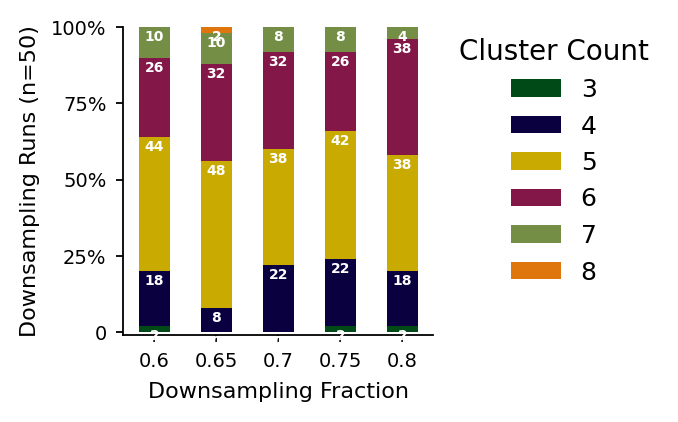

In [44]:
Clustering.louvain_clustering_stability_analysis(labels_dic, filename='CRISPR_Donwsampling')

<Figure size 400x200 with 0 Axes>

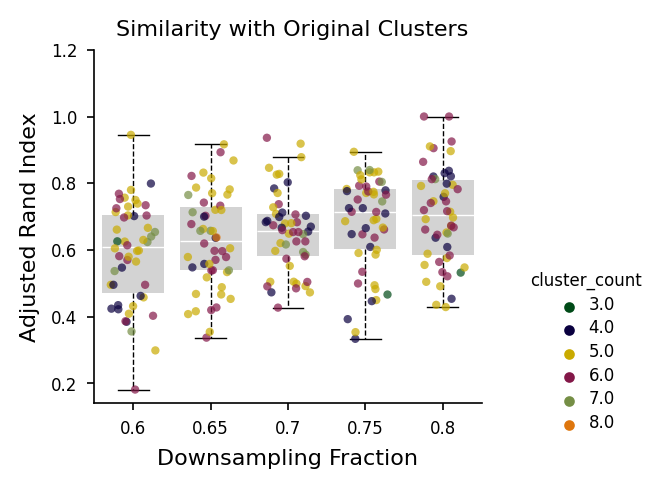

In [45]:
LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)
crispr_cluster_sr = LRT_upset_df['Cluster']
# crispr_cluster_sr = crispr_cluster_sr.drop(['SNU1196', 'SNU869'])

frac_color_dic = {frac:'lightgray' for frac in sorted(sample_fractions_l)}
Clustering.adjust_rand_index_downsampling_comparisons(crispr_cluster_sr, labels_dic, frac_color_dic, original_cluster_count=4,  ylim_top=1.2, filename='CRISPR_Donwsampling')

# Analyzing Differential Gene Expression Across Clusters

In [46]:
if new_upset_df is not None:
    LRT_upset_df = new_upset_df[['Cluster', 'Subtype']].copy()
else:
    LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
    LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)

rna_counts_file = 'Main_Data/RNA/rna_cell_lines_expected_counts.csv'
rna_counts_df = MyLib.load_csv(rna_counts_file, index_col=0)
rna_counts_df.index = rna_counts_df.index.map(lambda c:c.split(' (')[0])

cells_l = sorted(set(LRT_upset_df.index).intersection(set(rna_counts_df.columns)))
LRT_upset_df = LRT_upset_df.loc[cells_l]
rna_counts_df = rna_counts_df[cells_l]

def drop_zero_or_constant_cols(df):
    columns_to_drop = []
    for col in df.columns:
        if (df[col] == 0).all() or df[col].nunique() == 1:
            columns_to_drop.append(col)
    df.drop(columns=columns_to_drop, inplace=True)
    return df
rna_counts_df = drop_zero_or_constant_cols(rna_counts_df.T).T

print(rna_counts_df.shape)

input_data/Main_Data/RNA/rna_cell_lines_expected_counts.csv  is loaded, shape:  (17852, 76)

(17761, 36)


In [47]:
LRT_upset_df['Cluster'].value_counts()

D4    9
D3    8
D5    7
D6    5
D1    5
D2    2
Name: Cluster, dtype: int64

## set data

In [48]:
data_type = 'mRNA_hits_'
data_df = rna_counts_df
exp_filter = True
data_df.shape

(17761, 36)

## D1

Number of cell lines in D1: 5
[1] "Number of genes:11919"


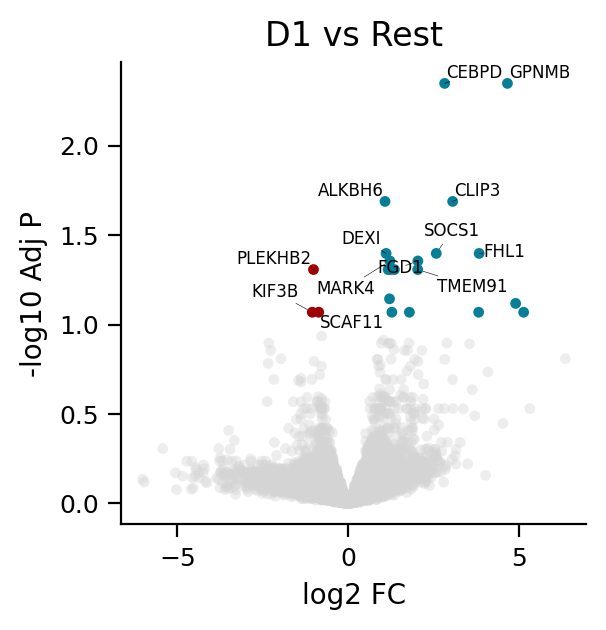


File  Figure7/output_fig7/mRNA_hits_D1_Rest_up.csv saved, shape: (19, 6)

File  Figure7/output_fig7/mRNA_hits_D1_Rest_down.csv saved, shape: (3, 6)


In [49]:
in_group = 'D1'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c1_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D2

Number of cell lines in D2: 2
[1] "Number of genes:11919"


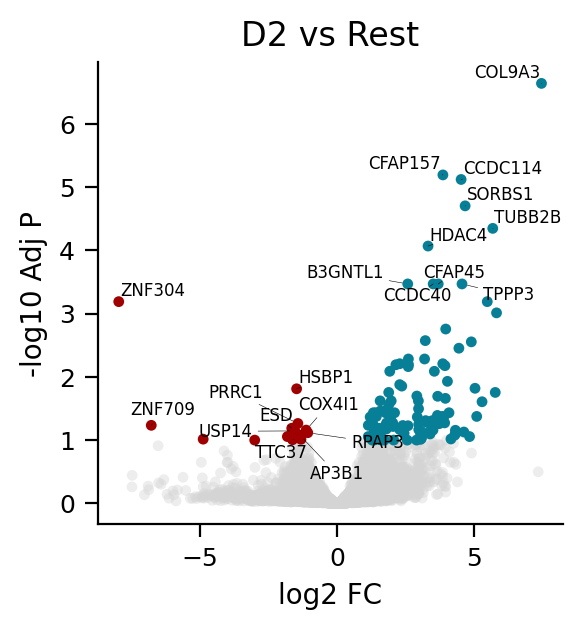


File  Figure7/output_fig7/mRNA_hits_D2_Rest_up.csv saved, shape: (108, 6)

File  Figure7/output_fig7/mRNA_hits_D2_Rest_down.csv saved, shape: (16, 6)


In [50]:
in_group = 'D2'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c2_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D3

Number of cell lines in D3: 8
[1] "Number of genes:11919"


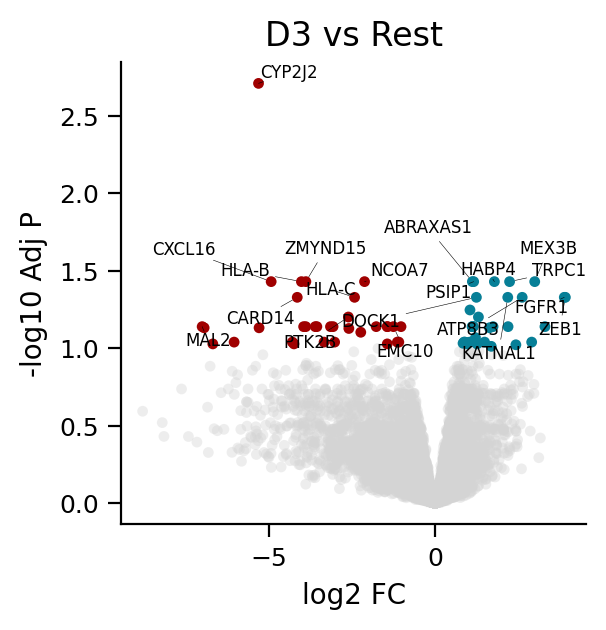


File  Figure7/output_fig7/mRNA_hits_D3_Rest_up.csv saved, shape: (32, 6)

File  Figure7/output_fig7/mRNA_hits_D3_Rest_down.csv saved, shape: (33, 6)


In [51]:
in_group = 'D3'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c3_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.3, force_points=.3, file_name=data_type, return_up=True)


 ## D4

Number of cell lines in D4: 9
[1] "Number of genes:11919"


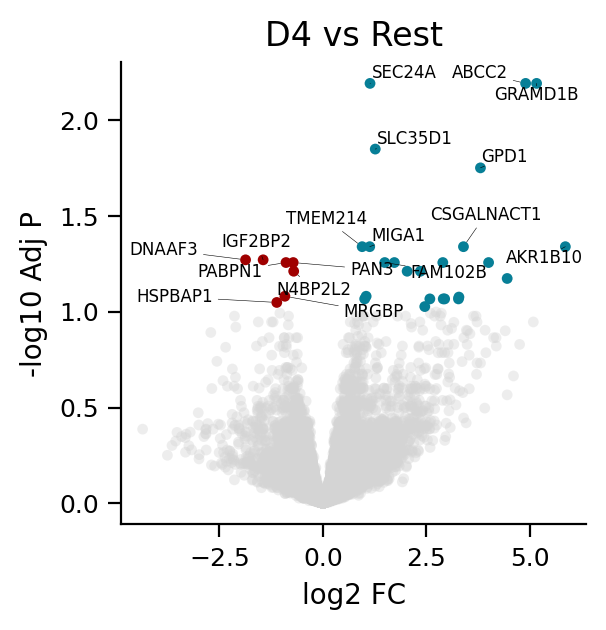


File  Figure7/output_fig7/mRNA_hits_D4_Rest_up.csv saved, shape: (24, 6)

File  Figure7/output_fig7/mRNA_hits_D4_Rest_down.csv saved, shape: (7, 6)


In [52]:
in_group = 'D4'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c4_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D5

Number of cell lines in D5: 7
[1] "Number of genes:11919"


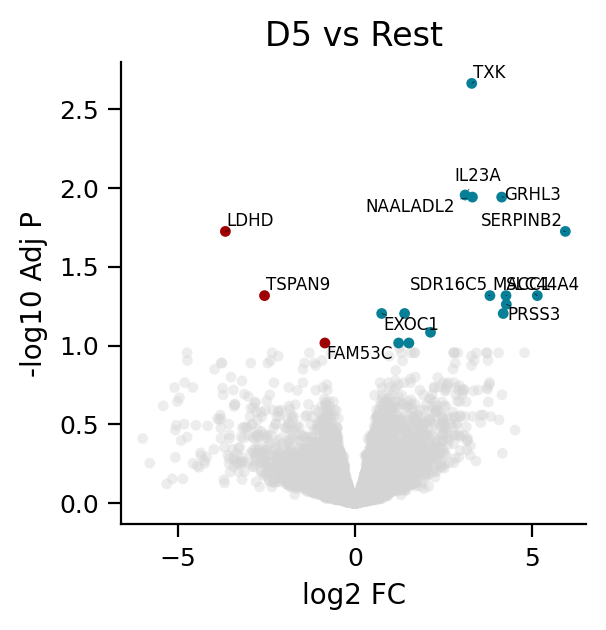


File  Figure7/output_fig7/mRNA_hits_D5_Rest_up.csv saved, shape: (15, 6)

File  Figure7/output_fig7/mRNA_hits_D5_Rest_down.csv saved, shape: (3, 6)


In [53]:
in_group = 'D5'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c5_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D6

Number of cell lines in D6: 5
[1] "Number of genes:11919"


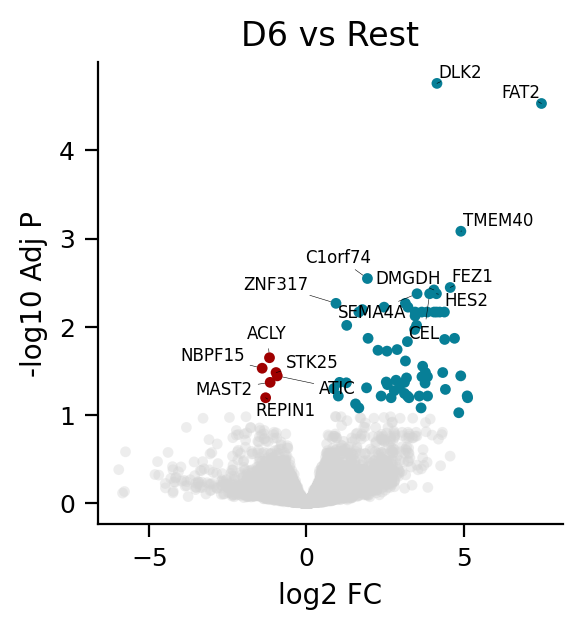


File  Figure7/output_fig7/mRNA_hits_D6_Rest_up.csv saved, shape: (67, 6)

File  Figure7/output_fig7/mRNA_hits_D6_Rest_down.csv saved, shape: (6, 6)


In [54]:
in_group = 'D6'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c6_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)